In [1]:
import sys
sys.path.insert(0, '../../')


In [2]:
import glob
import python_lib.graph_gen as graph_gen
import pandas as pd
# torch.set_num_threads(1)
import numpy as np

%matplotlib inline


In [3]:
data = {}


In [4]:
data_dir = "data/"
files = glob.glob(data_dir+"*.gzip")
# print(files)


In [5]:
model = "CW"
hh = 0.
JJ = 1.
seed = 0
Ns = [20, 50, 100, 200, 400, 800]
net_specs = ["exact"]
data_exact = {}
for N in Ns:
    data_exact[N] = pd.DataFrame()
    for net_spec in net_specs:
        name_f = f"N{N}_seed{seed}_model{model}_net_spec{net_spec}_2"
        res = [i for i in files if name_f in i]
        if len(res) == 1:
            def repl(name_col):
                return name_col.replace(net_spec, "")
            df_ = pd.read_pickle(res[0])
            df_ = df_.rename(repl, axis='columns')
            data_exact[N] = pd.concat([data_exact[N], df_], ignore_index=True)
            print(f"read: {res[0]}")
        elif len(res) > 1:
            print(res)

            def repl(name_col):
                return name_col.replace(net_spec, "")
            df_ = pd.read_pickle(res[0])
            df_ = df_.rename(repl, axis='columns')
            data_exact[N] = pd.concat([data_exact[N], df_], ignore_index=True)
            print(f"read: {res[0]}")
        else:
            print(f"not found: {name_f}")


read: data/N20_seed0_modelCW_net_specexact_20230224_002405.gzip
read: data/N50_seed0_modelCW_net_specexact_20230224_095311.gzip
read: data/N100_seed0_modelCW_net_specexact_20230224_104920.gzip
read: data/N200_seed0_modelCW_net_specexact_20230224_111618.gzip
read: data/N400_seed0_modelCW_net_specexact_20230224_152629.gzip
read: data/N800_seed0_modelCW_net_specexact_20230224_152634.gzip


In [6]:
net_specs = ["exact", "1Par", "CWARNN", "CWARNN_inf",
             "exact_Ninf", "sum_exp_exact", "MADE_21", "MADE_22", "SL"]
data = {}
for N in Ns:
    data[N] = pd.DataFrame()
    for net_spec in net_specs:
        #name_f = f"_model{model}_net_spec{net_spec}_N{N}_J{JJ:.2}_h{hh:.2}.gzip"
        name_f = f"N{N}_seed{seed}_model{model}_net_spec{net_spec}_2"
        res = [i for i in files if name_f in i]
        if len(res) == 1:
            def repl(name_col):
                return name_col.replace(net_spec, "")
            df_ = pd.read_pickle(res[0])
            df_ = df_.rename(repl, axis='columns')
            data[N] = pd.concat([data[N], df_], ignore_index=True)
            print(f"read: {res[0]}")
        elif len(res) > 1:
            print(res)

            def repl(name_col):
                return name_col.replace(net_spec, "")
            df_ = pd.read_pickle(res[0])
            df_ = df_.rename(repl, axis='columns')
            data[N] = pd.concat([data[N], df_], ignore_index=True)
            print(f"read: {res[0]}")


read: data/N20_seed0_modelCW_net_specexact_20230224_002405.gzip
read: data/N20_seed0_modelCW_net_spec1Par_20230223_220803.gzip
['data/N20_seed0_modelCW_net_specCWARNN_20230323_174823.gzip', 'data/N20_seed0_modelCW_net_specCWARNN_20230224_004811.gzip']
read: data/N20_seed0_modelCW_net_specCWARNN_20230323_174823.gzip
read: data/N20_seed0_modelCW_net_specCWARNN_inf_20230224_005857.gzip
read: data/N20_seed0_modelCW_net_specexact_Ninf_20230224_002533.gzip
read: data/N20_seed0_modelCW_net_specMADE_21_20230223_221900.gzip
read: data/N20_seed0_modelCW_net_specMADE_22_20230223_221956.gzip
read: data/N20_seed0_modelCW_net_specSL_20230224_101141.gzip
read: data/N50_seed0_modelCW_net_specexact_20230224_095311.gzip
read: data/N50_seed0_modelCW_net_spec1Par_20230224_101110.gzip
['data/N50_seed0_modelCW_net_specCWARNN_20230323_174906.gzip', 'data/N50_seed0_modelCW_net_specCWARNN_20230224_095540.gzip']
read: data/N50_seed0_modelCW_net_specCWARNN_20230323_174906.gzip
read: data/N50_seed0_modelCW_net_sp

In [7]:
data_all = {}
for N in Ns:
    print(N)
    data[N]["err_fe"] = 0
    data[N]["err_fe_rel"] = 0
    data[N]["err_fe_inf"] = 0
    data[N]["err_fe_rel_inf"] = 0

    to_set = []
    to_set_res = []
    to_set_inf = []
    to_set_res_inf = []
    for i in range(len(data[N])):
        beta = data[N].iloc[i]["beta"]
        fe_ex = data_exact[N][np.abs(
            data_exact[N]["beta"]-beta) < 1e-6]["free_energy"].item()
        fe_ex_inf = data[N][(np.abs(data[N]["beta"]-beta) < 1e-6) &
                            (data[N]["net_spec"] == "exact_Ninf")]["free_energy"].item()
        #print(beta, fe_ex)
        if np.isnan(data[N].iloc[i]["free_energy_mean"].item()):
            to_set.append(data[N].iloc[i]["free_energy"].item() - fe_ex)
            to_set_inf.append(
                data[N].iloc[i]["free_energy"].item() - fe_ex_inf)
        else:
            to_set.append(data[N].iloc[i]["free_energy_mean"].item() - fe_ex)
            to_set_inf.append(
                data[N].iloc[i]["free_energy_mean"].item() - fe_ex_inf)
        to_set_res.append(to_set[-1] / np.abs(fe_ex))
        to_set_res_inf.append(to_set_inf[-1] / np.abs(fe_ex_inf))
    data[N]["err_fe"] = to_set
    data[N]["err_fe_rel"] = to_set_res
    data[N]["err_fe_inf"] = to_set_inf
    data[N]["err_fe_rel_inf"] = to_set_res_inf
    data_all[N] = data[N].copy()


20
50
100
200
400
800


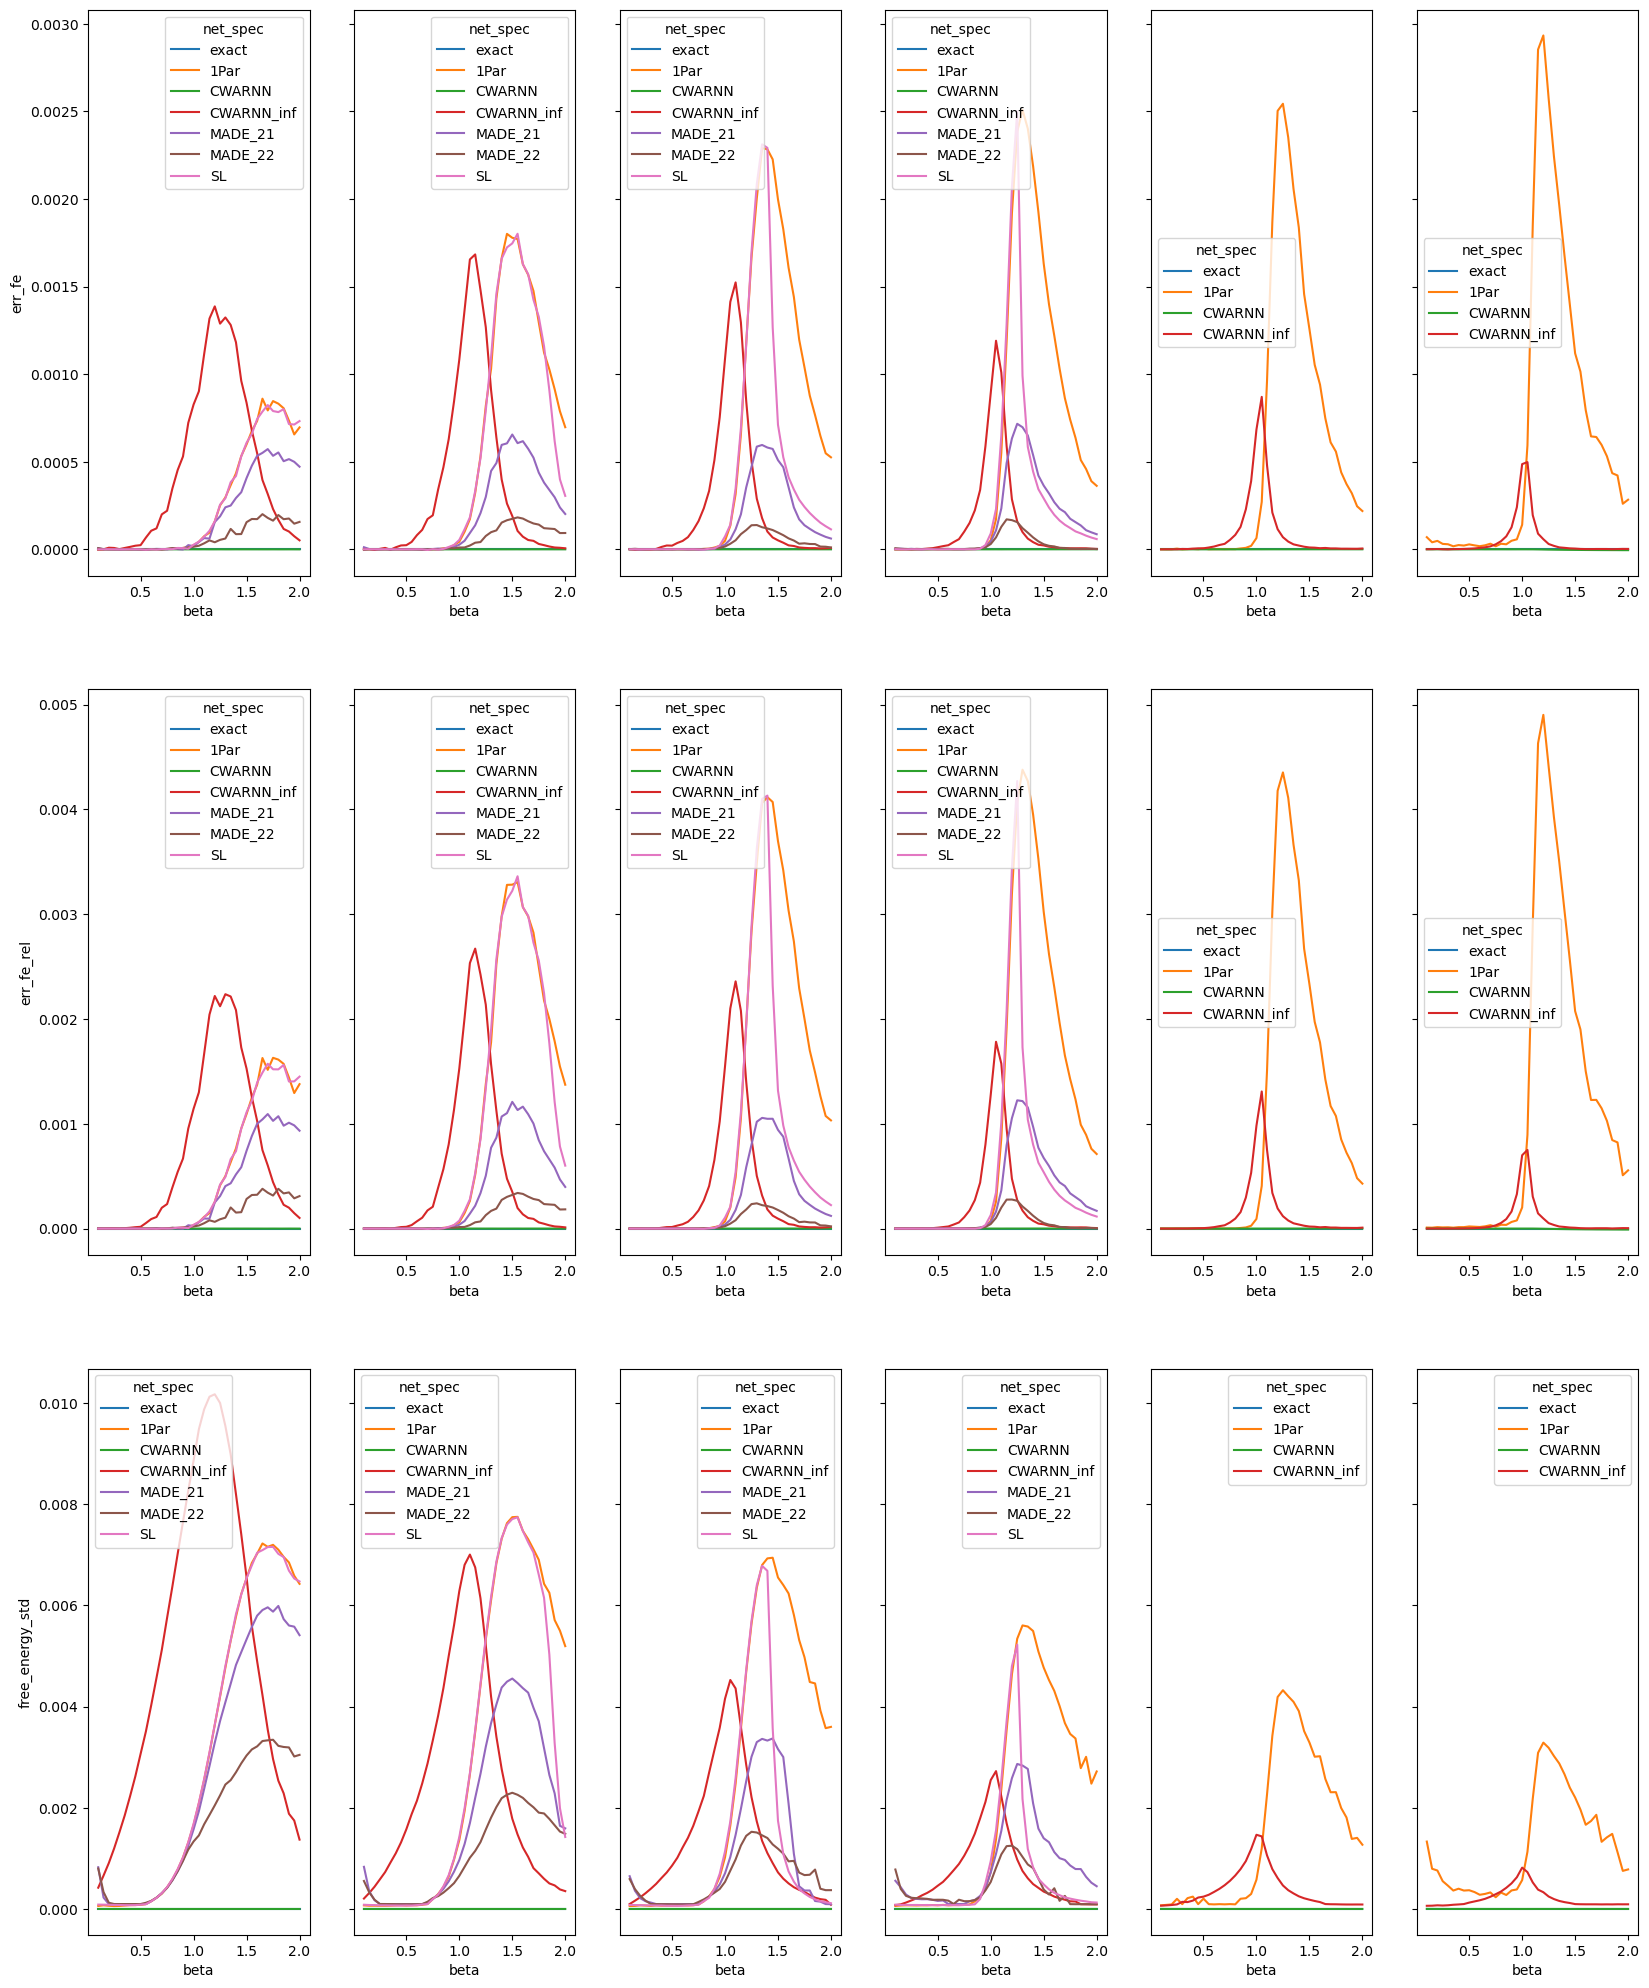

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

data_pl = {}
to_pl = ["exact", "1Par", "CWARNN", "CWARNN_inf",
         "exact_Ninf", "sum_exp_exact", "MADE_21", "MADE_22"]
to_pl = ["exact", "1Par", "CWARNN", "CWARNN_inf",
         "sum_exp_exact", "SL", "MADE_21", "MADE_22",]
#to_pl = ["exact", "exact_Ninf"]
for N in Ns:
    if len(data[N]) != 0:
        data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]

fig, axs = plt.subplots(3, len(Ns), figsize=(20, 25), sharey="row")
# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
for i, N in enumerate(Ns):
    if len(data[N]) != 0:
        sns.lineplot(data=data_pl[N], x="beta",
                     y="err_fe", hue="net_spec", ax=axs[0][i])

# N=10
# sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][0])
for i, N in enumerate(Ns):
    if len(data[N]) != 0:
        sns.lineplot(data=data_pl[N], x="beta",
                     y="err_fe_rel", hue="net_spec", ax=axs[1][i])

for i, N in enumerate(Ns):
    if len(data[N]) != 0:
        sns.lineplot(data=data_pl[N], x="beta",
                     y="free_energy_std", hue="net_spec", ax=axs[2][i])


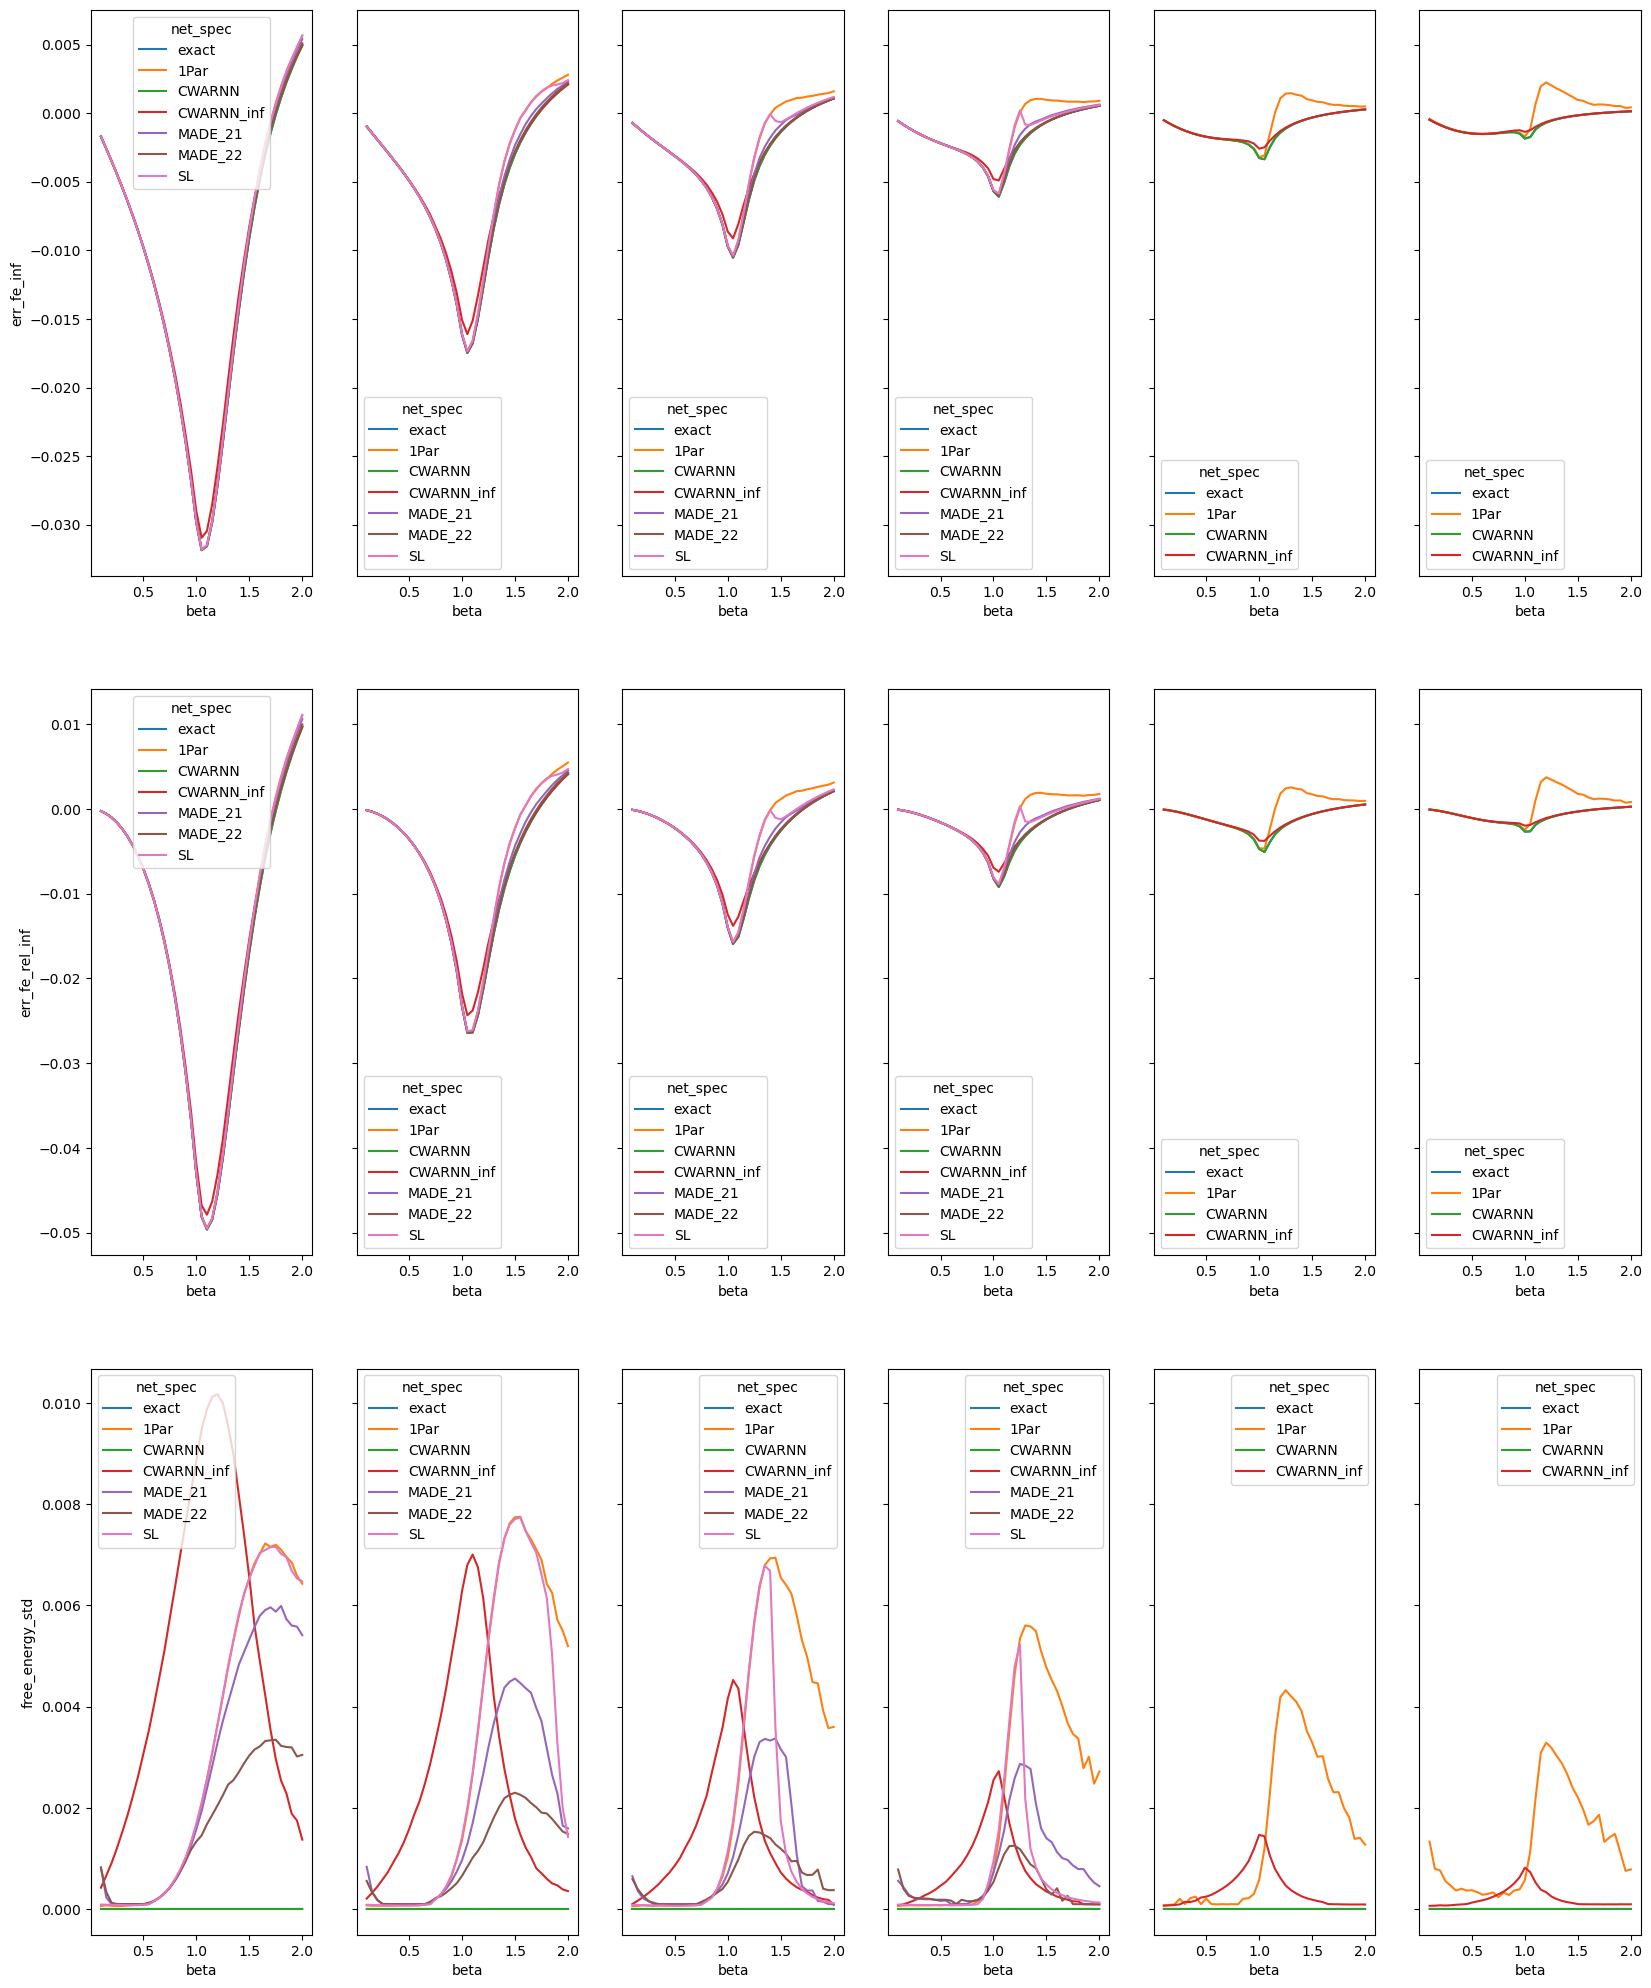

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

data_pl = {}
to_pl = ["exact", "1Par", "CWARNN", "CWARNN_inf",
         "exact_Ninf", "sum_exp_exact", "MADE_21", "MADE_22"]
to_pl = ["exact", "1Par", "CWARNN", "CWARNN_inf",
         "sum_exp_exact", "SL", "MADE_21", "MADE_22",]
#to_pl = ["exact", "exact_Ninf"]
for N in Ns:
    if len(data[N]) != 0:
        data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]

fig, axs = plt.subplots(3, len(Ns), figsize=(20, 25), sharey="row")
# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
for i, N in enumerate(Ns):
    if len(data[N]) != 0:
        sns.lineplot(data=data_pl[N], x="beta",
                     y="err_fe_inf", hue="net_spec", ax=axs[0][i])

# N=10
# sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][0])
for i, N in enumerate(Ns):
    if len(data[N]) != 0:
        sns.lineplot(data=data_pl[N], x="beta",
                     y="err_fe_rel_inf", hue="net_spec", ax=axs[1][i])

for i, N in enumerate(Ns):
    if len(data[N]) != 0:
        sns.lineplot(data=data_pl[N], x="beta",
                     y="free_energy_std", hue="net_spec", ax=axs[2][i])


In [10]:
data_q = pd.DataFrame()
seeds = [0]
to_pl = ["1Par", "CWARNN", "CWARNN_inf",
         "sum_exp_exact", "SL", "MADE_21", "MADE_22",]
data_dir = "data/"
files_q = glob.glob(data_dir+"*.gzip")

for seed in seeds:
    for N in Ns:
        for net_spec in to_pl:
            name_f = f"N{N}_seed{seed}_model{model}_net_spec{net_spec}_2"
            res = [i for i in files_q if name_f in i]
            if len(res) == 1:
                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                data_q = pd.concat([data_q, df_], ignore_index=True)
                print(f"read: {res[0]}")
            elif len(res) > 1:
                print(res)

                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                df_["N"] = int(N)
                data_q = pd.concat([data_q, df_], ignore_index=True)
                print(f"read: {res[0]}")
data_q = data_q.astype({'N': 'int32'})


read: data/N20_seed0_modelCW_net_spec1Par_20230223_220803.gzip
['data/N20_seed0_modelCW_net_specCWARNN_20230323_174823.gzip', 'data/N20_seed0_modelCW_net_specCWARNN_20230224_004811.gzip']
read: data/N20_seed0_modelCW_net_specCWARNN_20230323_174823.gzip
read: data/N20_seed0_modelCW_net_specCWARNN_inf_20230224_005857.gzip
read: data/N20_seed0_modelCW_net_specSL_20230224_101141.gzip
read: data/N20_seed0_modelCW_net_specMADE_21_20230223_221900.gzip
read: data/N20_seed0_modelCW_net_specMADE_22_20230223_221956.gzip
read: data/N50_seed0_modelCW_net_spec1Par_20230224_101110.gzip
['data/N50_seed0_modelCW_net_specCWARNN_20230323_174906.gzip', 'data/N50_seed0_modelCW_net_specCWARNN_20230224_095540.gzip']
read: data/N50_seed0_modelCW_net_specCWARNN_20230323_174906.gzip
read: data/N50_seed0_modelCW_net_specCWARNN_inf_20230224_101847.gzip
read: data/N50_seed0_modelCW_net_specSL_20230224_102648.gzip
read: data/N50_seed0_modelCW_net_specMADE_21_20230224_103932.gzip
read: data/N50_seed0_modelCW_net_spe

In [11]:
"""binned_q = pd.read_csv("./data/overlaps.zip")
# plot the histograms
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

to_plt = [replacement[key] for key in replacement]
for name in to_plt:
    #print(name)
    y = binned_q[name]
    x = binned_q["bins"]
    color = next(colors)
    #axs[1][1].plot(x=x, y=y, color=color,label=name, legend=False)
"""


'binned_q = pd.read_csv("./data/overlaps.zip")\n# plot the histograms\ncolors = itertools.cycle(plt.rcParams[\'axes.prop_cycle\'].by_key()[\'color\'])\n\nto_plt = [replacement[key] for key in replacement]\nfor name in to_plt:\n    #print(name)\n    y = binned_q[name]\n    x = binned_q["bins"]\n    color = next(colors)\n    #axs[1][1].plot(x=x, y=y, color=color,label=name, legend=False)\n'

/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_8696/3210215115.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pl[N]['net_spec'] = data_pl[N]['net_spec'].replace(replacement)
/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_8696/3210215115.py:58: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=data_pl[N1], x="beta", y="err_fe",


/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_8696/3210215115.py:64: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=data_pl[N2], x="beta", y="err_fe",
/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_8696/3210215115.py:69: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=data_pl[N3], x="beta", y="err_fe",
/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_8696/3210215115.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pl[N]['net_spec'] = data_pl[N]['net_spec'].replace(replacement)
/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_8696/3210215115.py:106: UserWarning: T

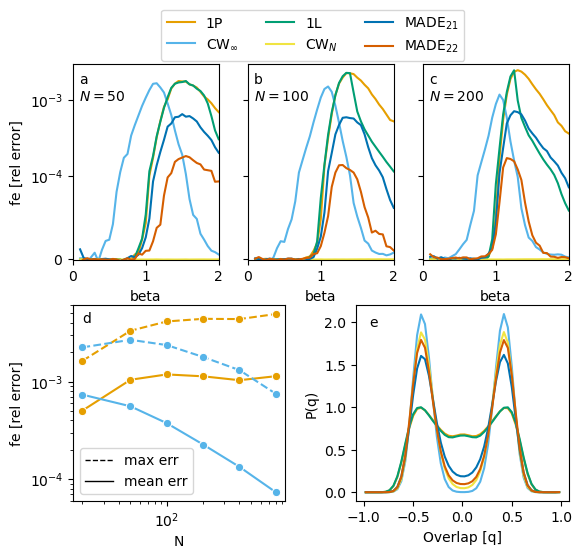

In [23]:
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Okabe-Ito colors
colors = ['#E69F00', '#56B4E9', '#009E73',
          '#F0E442', '#0072B2', '#D55E00', '#CC79A7']


Ns = [20, 50, 100, 200, 400, 800]
data_pl = {}
to_pl_old = ["exact", "1Par", "CWARNN",
             "CWARNN_inf", "SL", "MADE_21", "MADE_22",]


for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl_old)]

replacement = {'1Par': '1P', 'CWARNN_inf': 'CW$_{\infty}$', 'SL': '1L',
               'CWARNN': 'CW$_N$', 'MADE_21': 'MADE$_{21}$', 'MADE_22': 'MADE$_{22}$'}
for N in Ns:
    data_pl[N]['net_spec'] = data_pl[N]['net_spec'].replace(replacement)

to_plt = [replacement[key] for key in replacement]

# PLOT FIRST TREE FREE ENERGY ESTIMATES
all_N = pd.DataFrame()
all_N = pd.concat([data_pl[xx] for xx in data_pl])
all_N["N"] = pd.to_numeric(all_N["N"])

fig = plt.figure(constrained_layout=False, figsize=(6.4, 5.6))
gs = fig.add_gridspec(2, 1)

gs00 = gs[0].subgridspec(1, 3)
gs01 = gs[1].subgridspec(1, 2)

axs = [[], []]
axs[0].append(fig.add_subplot(gs00[0, 0]))
axs[0].append(fig.add_subplot(gs00[0, 1]))
axs[0].append(fig.add_subplot(gs00[0, 2]))
axs[1].append(fig.add_subplot(gs01[0, 0]))
axs[1].append(fig.add_subplot(gs01[0, 1]))

# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
N1 = Ns[1]
linthresh = 1e-4
ylimp = 0.003
ylimm = -0.000001

# Okabe-Ito colors
colors = ['#E69F00', '#56B4E9', '#009E73',
          '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

# Your sns.lineplot command
sns.lineplot(data=data_pl[N1], x="beta", y="err_fe",
             hue="net_spec", ax=axs[0][0], hue_order=to_plt, palette=colors)
# axs[0][0].set_yscale('log')
axs[0][0].set_yscale('symlog', linthresh=linthresh)

N2 = Ns[2]
sns.lineplot(data=data_pl[N2], x="beta", y="err_fe",
             hue="net_spec", ax=axs[0][1], hue_order=to_plt, palette=colors)
axs[0][1].set_yscale('symlog', linthresh=linthresh)

N3 = Ns[3]
sns.lineplot(data=data_pl[N3], x="beta", y="err_fe",
             hue="net_spec", ax=axs[0][2], hue_order=to_plt, palette=colors)
axs[0][2].set_yscale('symlog', linthresh=linthresh)

# PLOT THE OVERLAPS

beta = 1.2
N = 200

binned_q = pd.read_csv("./data/overlaps.zip")
# plot the histograms

to_plt = [replacement[key] for key in replacement]
for name in replacement.keys():
    # print(name)
    y = binned_q[name]
    x = binned_q["bins"]
    color = colors[to_plt.index(replacement[name])]
    axs[1][1].plot(x, y, color=color, label=replacement[name])


data_pl = {}
to_pl = ['1Par', 'CWARNN_inf']

for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]

for N in Ns:
    data_pl[N]['net_spec'] = data_pl[N]['net_spec'].replace(replacement)

to_plt = [replacement[key] for key in replacement]

all_N = pd.DataFrame()
all_N = pd.concat([data_pl[xx] for xx in data_pl])
all_N["N"] = pd.to_numeric(all_N["N"])

#_all_ = all_N.groupby(["N", "net_spec"]).reset_index()
pl_mean = sns.lineplot(data=all_N, x="N", y="err_fe_rel", hue="net_spec",
                       ax=axs[1][0], estimator=np.mean, errorbar=None, marker="o", hue_order=to_plt, palette=colors)

pl_max = sns.lineplot(data=all_N, x="N", y="err_fe_rel", hue="net_spec",
                      ax=axs[1][0], estimator=np.max, errorbar=None, marker="o", linestyle='--', hue_order=to_plt, palette=colors)


axs[0][0].set_ylim(ylimm, ylimp)
axs[0][1].set_ylim(ylimm, ylimp)
axs[0][2].set_ylim(ylimm, ylimp)
axs[0][0].set_xlim(-0., 2.)
axs[0][1].set_xlim(-0., 2.)
axs[0][2].set_xlim(-0., 2.)
# axs[0][0].set_title(f"N: {N1}")
# axs[0][1].set_title(f"N: {N2}")
# axs[0][2].set_title(f"N: {N3}")
axs[0][1].set_yticklabels([])
axs[0][2].set_yticklabels([])
axs[0][2].set_ylabel("")
axs[0][1].set_ylabel("")
axs[0][0].set_ylabel("fe [rel error]")
axs[1][0].set_ylabel("fe [rel error]")

axs[1][1].set_xlabel("Overlap [q]")
axs[1][1].set_ylabel("P(q)")

# axs[1][0].set_yscale("log")
# axs[1][0].set_xscale("log")
axs[1][0].set_yscale("log")
axs[1][0].set_xscale("log")

axs[0][2].get_legend().remove()
axs[0][1].get_legend().remove()
axs[0][0].get_legend().remove()
# axs[1][0].legend("")
# axs[0][0].legend(handlelength=1,)

# Get handles and labels from one of the plots (e.g., from axs[0][0])
handles, labels = axs[0][0].get_legend_handles_labels()

# Add a unified legend at the desired position
fig.legend(handles, labels, loc='upper center',
           ncol=3, bbox_to_anchor=(0.5, 0.99))


axs[0][0].text(0.08, 0.001, "a\n$N=50$")
axs[0][1].text(0.08, 0.001, "b\n$N=100$")
axs[0][2].text(0.08, 0.001, "c\n$N=200$")
# axs[0][0].text(1.2, 0.003, r"$N=50$")
# axs[0][1].text(1.2, 0.003, r"$N=100$")
# axs[0][2].text(1.2, 0.003, r"$N=200$")
axs[1][0].text(20, 4e-3, "d")
axs[1][1].text(-0.95, 1.95, "e")


custom_lines = [Line2D([0], [0], ls="--", color="black", lw=1),
                Line2D([0], [0], ls="-", color="black", lw=1),]
axs[1][0].legend(custom_lines, ['max err', 'mean err'])

#plt.subplots_adjust(top=0.9, hspace=0.2, wspace=0.2)
# Adjust the horizontal spacing for the second row of plots
for i, ax in enumerate(axs[1]):
    pos = ax.get_position()
    if i == 0:  # for the first subplot of the second row
        # Adjust the 0.05 value to reduce the width of the first subplot or shift it left
        new_right = pos.x1 - 0.02
        ax.set_position([pos.x0, pos.y0, new_right - pos.x0, pos.height])
    elif i == 1:  # for the second subplot of the second row
        # Adjust the 0.05 value to reduce the width of the second subplot or shift it right
        new_left = pos.x0 + 0.02
        ax.set_position([new_left, pos.y0, pos.x1 - new_left, pos.height])

for ax in axs[1]:
    pos = ax.get_position()
    new_bottom = pos.y0 - 0.01  # Adjust the 0.05 value as needed to shift the subplot down
    # Adjust the 0.05 value as needed to reduce the height or shift the subplot down
    new_top = pos.y1 - 0.01
    ax.set_position([pos.x0, new_bottom, pos.width, new_top - new_bottom])

# plt.tight_layout()
plt.savefig("../tex/comphys_rev_3/img/CW_res.pdf", bbox_inches='tight')
